In [ ]:
# import sys
# !{sys.executable} -m pip install tensorflow

In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import (ElectraForSequenceClassification, ElectraTokenizerFast)

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

# Get data

In [2]:
df = pd.read_csv('./../../labeledTweets/allLabeledTweets.csv')
df = df[['id', 'message', 'label']]
df.head()

,id,message,label
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0
1,1478695,Augulis: #airBaltic “potenciālie pircēji ir no...,0
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0


In [3]:
df['label'].value_counts()

0    968
2    647
1    410
Name: label, dtype: int64

In [4]:
newLine ="\\n|\\r"
urls = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
numbers = '\d+((\.|\-)\d+)?'
mentions = '\B\@([\w\-]+)'
hashtag = '#'
whitespaces = '\s+'
leadTrailWhitespace = '^\s+|\s+?$'

df['clean_message'] = df['message']
df['clean_message'] = df['clean_message'].str.replace(newLine,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(urls,' URL ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(mentions,' MENTION ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(numbers,' NMBR ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(hashtag,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(whitespaces,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(leadTrailWhitespace,'',regex=True)

df.head()

,id,message,label,clean_message
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0,Tiek vērtēti trīs potenciālie airBaltic invest...
1,1478695,Augulis: #airBaltic “potenciālie pircēji ir no...,0,Augulis: airBaltic “potenciālie pircēji ir no ...
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0,airBaltic uzsāks lidojumus uz diviem jauniem g...
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0,Ministrs: Sarunas turpinās ar trīs potenciālaj...
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0,MENTION MENTION MENTION Netrāpīs kādam AirBalt...


# Train, validate split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [6]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['label', 'data_type']).count()

id  message  clean_message
label data_type                             
0     train      823      823            823
      val        145      145            145
1     train      348      348            348
      val         62       62             62
2     train      550      550            550
      val         97       97             97

In [7]:
df.head()

,id,message,label,clean_message,data_type
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0,Tiek vērtēti trīs potenciālie airBaltic invest...,train
1,1478695,Augulis: #airBaltic “potenciālie pircēji ir no...,0,Augulis: airBaltic “potenciālie pircēji ir no ...,val
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0,airBaltic uzsāks lidojumus uz diviem jauniem g...,train
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0,Ministrs: Sarunas turpinās ar trīs potenciālaj...,train
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0,MENTION MENTION MENTION Netrāpīs kādam AirBalt...,train


## Balance training data

In [8]:
df[df.data_type=='train']['label'].value_counts()

0    823
2    550
1    348
Name: label, dtype: int64

In [9]:
df_train = [df[df.data_type=='train'].clean_message, df[df.data_type=='train'].label]
df_train = pd.concat(df_train, axis=1, keys=["clean_message", "label"])

df_0 = df_train[df_train['label']==0]
df_1 = df_train[df_train['label']==1]
df_2 = df_train[df_train['label']==2]

df_0_downsampled = df_0.sample(df_1.shape[0], random_state=42)
df_2_downsampled = df_2.sample(df_1.shape[0], random_state=42)

df_train = pd.concat([df_0_downsampled, df_2_downsampled, df_1])

df_train['label'].value_counts()

0    348
1    348
2    348
Name: label, dtype: int64

In [10]:
# Shuffle rows
import sklearn

df_train = sklearn.utils.shuffle(df_train, random_state=0)

df_train.head()

,clean_message,label
700,Šodien norisinās SEB MTB maratons. Finišs MENT...,0
1911,MENTION Sveiks! Tas neattiecas uz mūsu ekspert...,1
505,"MENTION MENTION Starpcitu, Maxima tirgo labus ...",1
1471,Taisnība ir uzvarējusi! Martins Dukurs kļūst p...,1
1537,MENTION Спасибо за мнение.^el,0


# Tokenizer "google/electra-base-discriminator"

In [11]:
tokenizer = ElectraTokenizerFast.from_pretrained("google/electra-base-discriminator", do_lower_case=True)  

### Find max length for tokenizer

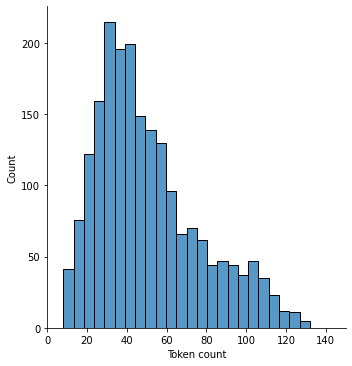

In [12]:
token_lens = []
for txt in list(df.clean_message.values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
sns.displot(token_lens)
plt.xlim([0, 150])
plt.xlabel('Token count')
plt.show()

In [13]:
max_length = 130

### Encode messages

In [14]:
encoded_data_train = tokenizer.batch_encode_plus(
    df_train["clean_message"].values.tolist(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].clean_message.values.tolist(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_train.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\aligo\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [15]:
len(dataset_train), len(dataset_val)

(1044, 304)

In [ ]:
# torch.save(dataset_train, './datasetsLowercase/dataset_train.pt')
# torch.save(dataset_val, './datasetsLowercase/dataset_val.pt')

In [ ]:
# dataset_train = torch.load('./datasetsLowercase/dataset_train.pt')
# dataset_val = torch.load('./datasetsLowercase/dataset_val.pt')

In [ ]:
# len(dataset_train), len(dataset_val)

# Model "google/electra-base-discriminator"

In [16]:
model = ElectraForSequenceClassification.from_pretrained("google/electra-base-discriminator", num_labels = 3)

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.o

In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

In [18]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)

In [19]:
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

In [20]:
# Function to measure weighted F1

from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [21]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
model.to(device)
print(device)

cpu


In [22]:
# Function to evaluate model. Returns average validation loss, predictions, true values

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

# Train

In [23]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'modelsCleaned/finetuned_ELECTRA_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    preds_flat = np.argmax(predictions, axis=1).flatten()
    
    print('Classification report:')
    print(classification_report(true_vals, preds_flat))
    print('Confusion matrix:')
    print(pd.DataFrame(confusion_matrix(true_vals, preds_flat),
            index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
            columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']]))
    print('--------------------------------------------------------------')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0950576681079287
Validation loss: 1.0587759613990784
F1 Score (Weighted): 0.5028793407596172
Classification report:
              precision    recall  f1-score   support

           0       0.61      0.65      0.63       145
           1       0.62      0.08      0.14        62
           2       0.45      0.67      0.54        97

    accuracy                           0.54       304
   macro avg       0.56      0.47      0.44       304
weighted avg       0.57      0.54      0.50       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         94        3       48
       positive        27        5       30
       negative        32        0       65
--------------------------------------------------------------


Epoch 2:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.053226767164288
Validation loss: 1.0061935842037202
F1 Score (Weighted): 0.6097373755769312
Classification report:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       145
           1       0.54      0.32      0.40        62
           2       0.55      0.70      0.62        97

    accuracy                           0.62       304
   macro avg       0.60      0.57      0.57       304
weighted avg       0.62      0.62      0.61       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral        100        9       36
       positive        23       20       19
       negative        21        8       68
--------------------------------------------------------------


Epoch 3:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.007790294560519
Validation loss: 0.9763112187385559
F1 Score (Weighted): 0.621384177289807
Classification report:
              precision    recall  f1-score   support

           0       0.66      0.72      0.69       145
           1       0.52      0.45      0.48        62
           2       0.63      0.59      0.61        97

    accuracy                           0.62       304
   macro avg       0.60      0.59      0.59       304
weighted avg       0.62      0.62      0.62       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral        105       15       25
       positive        26       28        8
       negative        29       11       57
--------------------------------------------------------------


Epoch 4:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.9734179016315576
Validation loss: 0.9754792273044586
F1 Score (Weighted): 0.5836569413772713
Classification report:
              precision    recall  f1-score   support

           0       0.71      0.53      0.61       145
           1       0.36      0.53      0.43        62
           2       0.62      0.67      0.64        97

    accuracy                           0.58       304
   macro avg       0.56      0.58      0.56       304
weighted avg       0.61      0.58      0.58       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         77       38       30
       positive        19       33       10
       negative        12       20       65
--------------------------------------------------------------


Epoch 5:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.940368733622811
Validation loss: 0.9684656202793122
F1 Score (Weighted): 0.5914648163583923
Classification report:
              precision    recall  f1-score   support

           0       0.70      0.56      0.62       145
           1       0.38      0.50      0.43        62
           2       0.62      0.68      0.65        97

    accuracy                           0.59       304
   macro avg       0.57      0.58      0.57       304
weighted avg       0.61      0.59      0.59       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         81       33       31
       positive        21       31       10
       negative        13       18       66
--------------------------------------------------------------


# Evaluate

In [ ]:
model.load_state_dict(torch.load('modelsCleaned/finetuned_ELECTRA_epoch_X.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
preds_flat = np.argmax(predictions, axis=1).flatten()

In [ ]:
print(classification_report(true_vals, preds_flat))

In [ ]:
pd.DataFrame(confusion_matrix(true_vals, preds_flat),
        index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
        columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])